In [218]:
import hail as hl
import os
import hail.expr.aggregators as agg
import math
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from collections import Counter
from math import log, isnan
from pprint import pprint
from bokeh.io import show, output_notebook
from bokeh.plotting import figure
from bokeh.layouts import gridplot
from bokeh.models import Span
output_notebook()

Loading BokehJS ...

In [2]:
hl.init()

Running on Apache Spark version 2.2.0
SparkUI available at http://10.1.7.107:4041
Welcome to
     __  __     <>__
    / /_/ /__  __/ /
   / __  / _ `/ / /
  /_/ /_/\_,_/_/_/   version devel-7df00f17d68d
NOTE: This is a beta version. Interfaces may change
  during the beta period. We recommend pulling
  the latest changes weekly.


In [3]:
hl.utils.get_1kg('data/')
ds = hl.read_matrix_table('data/1kg.mt')

table = (hl.import_table('data/1kg_annotations.txt', impute=True)
         .key_by('Sample'))

ds = ds.annotate_cols(**table[ds.s])
ds = hl.sample_qc(ds)
ds = ds.filter_cols((ds.sample_qc.dp_mean >= 4) & (ds.sample_qc.call_rate >= 0.97))

ab = ds.AD[1] / hl.sum(ds.AD)
filter_condition_ab = ((ds.GT.is_hom_ref() & (ab <= 0.1)) |
                        (ds.GT.is_het() & (ab >= 0.25) & (ab <= 0.75)) |
                        (ds.GT.is_hom_var() & (ab >= 0.9)))
ds = ds.filter_entries(filter_condition_ab)

ds = hl.variant_qc(ds)

2018-06-18 15:04:15 Hail: INFO: 1KG files found
2018-06-18 15:04:15 Hail: INFO: Reading table to impute column types
2018-06-18 15:04:16 Hail: INFO: Finished type imputation
  Loading column 'Sample' as type 'str' (imputed)
  Loading column 'Population' as type 'str' (imputed)
  Loading column 'SuperPopulation' as type 'str' (imputed)
  Loading column 'isFemale' as type 'bool' (imputed)
  Loading column 'PurpleHair' as type 'bool' (imputed)
  Loading column 'CaffeineConsumption' as type 'float64' (imputed)
2018-06-18 15:04:16 Hail: INFO: Coerced sorted dataset


In [4]:
# GWAS
common_ds = ds.filter_rows(ds.variant_qc.AF[1] > 0.01)
gwas = hl.linear_regression(y=common_ds.CaffeineConsumption, x=common_ds.GT.n_alt_alleles())

2018-06-18 15:04:30 Hail: INFO: linear_regression: running on 250 samples for 1 response variable y,
    with input variable x, intercept, and 0 additional covariates...


In [5]:
# address confounding
pca_eigenvalues, pca_scores, _ = hl.hwe_normalized_pca(common_ds.GT)

cds = common_ds.annotate_cols(pca = pca_scores[common_ds.s])

linear_regression_results = hl.linear_regression(
    y=cds.CaffeineConsumption, x=cds.GT.n_alt_alleles(),
    covariates=[cds.isFemale, cds.pca.scores[0], cds.pca.scores[1], cds.pca.scores[2]])

2018-06-18 15:04:38 Hail: INFO: hwe_normalized_pca: running PCA using 9169 variants.
2018-06-18 15:04:42 Hail: INFO: pca: running PCA with 10 components...
2018-06-18 15:04:58 Hail: INFO: linear_regression: running on 250 samples for 1 response variable y,
    with input variable x, intercept, and 4 additional covariates...


In [6]:
# p-values for caffeine consumption
caffeine_pval_tbl = (linear_regression_results
       .select_rows(linear_regression_results.rsid, 
                    linear_regression_results.qual, 
                    linear_regression_results.linreg.p_value)
       .select_entries()
       .rows())
caffeine_pval_tbl.describe()
caffeine_pval_tbl.show(10)

----------------------------------------
Global fields:
    None
----------------------------------------
Row fields:
    'locus': locus<GRCh37> 
    'alleles': array<str> 
    'rsid': str 
    'qual': float64 
    'p_value': float64 
----------------------------------------
Key: ['locus', 'alleles']
----------------------------------------
+---------------+------------+------+-------------+-------------+
| locus         | alleles    | rsid |        qual |     p_value |
+---------------+------------+------+-------------+-------------+
| locus<GRCh37> | array<str> | str  |     float64 |     float64 |
+---------------+------------+------+-------------+-------------+
| 1:904165      | ["G","A"]  | NA   | 5.23464e+04 | 1.80882e-01 |
| 1:1563691     | ["T","G"]  | NA   | 1.09075e+03 | 4.63369e-01 |
| 1:1707740     | ["T","G"]  | NA   | 9.35178e+04 | 8.80793e-01 |
| 1:2284195     | ["T","C"]  | NA   | 1.42481e+05 | 4.33107e-01 |
| 1:2779043     | ["T","C"]  | NA   | 2.88792e+05 | 3.57754e-02

In [7]:
# position stats (max, min, etc...)
pos_info = (caffeine_pval_tbl
            .group_by(caffeine_pval_tbl.locus.contig)
            .aggregate(pos_stats = agg.stats(caffeine_pval_tbl.locus.position)))
pos_info.show(23, width=150)

2018-06-18 15:05:59 Hail: INFO: Ordering unsorted dataset with network shuffle


+--------+----------------+-----------------+---------------+---------------+-------------+---------------+
| contig | pos_stats.mean | pos_stats.stdev | pos_stats.min | pos_stats.max | pos_stats.n | pos_stats.sum |
+--------+----------------+-----------------+---------------+---------------+-------------+---------------+
| str    |        float64 |         float64 |       float64 |       float64 |       int64 |       float64 |
+--------+----------------+-----------------+---------------+---------------+-------------+---------------+
| 1      |    1.31236e+08 |     7.64853e+07 |   9.04165e+05 |   2.48856e+08 |         743 |   9.75085e+10 |
| 10     |    6.79743e+07 |     4.21169e+07 |   3.23283e+05 |   1.35370e+08 |         460 |   3.12682e+10 |
| 11     |    6.58828e+07 |     4.37191e+07 |   2.36091e+05 |   1.34823e+08 |         458 |   3.01743e+10 |
| 12     |    6.74547e+07 |     4.20535e+07 |   2.75065e+05 |   1.33781e+08 |         471 |   3.17712e+10 |
| 13     |    7.09380e+07 | 

In [18]:
# convert locus to global positions for manhattan plotting
# get negative log of p_values for manhattan plotting
caffeine_pval_tbl.describe()

# caffeine_pval_tbl.count()      --> 9177

def getGlobalPosition(contig, position):
    locus = hl.Locus(contig, position)
    return locus._rg._jrep.locusToGlobalPos(locus._jrep)


----------------------------------------
Global fields:
    None
----------------------------------------
Row fields:
    'locus': locus<GRCh37> 
    'alleles': array<str> 
    'rsid': str 
    'qual': float64 
    'p_value': float64 
----------------------------------------
Key: ['locus', 'alleles']
----------------------------------------


In [ ]:
manhattan_collected = caffeine_pval_tbl.select('p_value').collect()

In [19]:
def convertContigStringToInt(contig):
    if (contig == 'X'):
        return 23
    if (contig == 'Y'):
        return 24
    else :
        return int(contig)
    
def getNegativeLog(pval):
    return -log(pval)

manhattan_xy = list(map(
    lambda strct: [convertContigStringToInt(strct.locus.contig),
                   getGlobalPosition(strct.locus.contig, strct.locus.position), 
                   getNegativeLog(strct.p_value)], 
    manhattan_collected))

In [95]:
print(manhattan_xy[0])
manhattan_xy_np = np.matrix(manhattan_xy)
print(len(manhattan_xy_np))
print(manhattan_xy_np.shape)
print("min global pos: ",min(manhattan_xy_np[:,1]))
print("max global pos: ",max(manhattan_xy_np[:,1]))
print("min neg log pval: ", min(manhattan_xy_np[:,2]))
print("max neg log pval: ", max(manhattan_xy_np[:, 2]))
print("indices of max values: ", np.nanargmax(manhattan_xy_np, axis=0))
print("pos: ", manhattan_xy_np[7909,1]," pval: ", manhattan_xy_np[7909,2])

[1, 904164, 1.7099108771957419]
9177
(9177, 3)
min global pos:  [[ 904164.]]
max global pos:  [[  3.03512065e+09]]
min neg log pval:  [[  5.13047223e-06]]
max neg log pval:  [[ 10.59282893]]
indices of max values:  [[8938 9176 7909]]
pos:  2583572416.0  pval:  10.5928289338


In [21]:
import csv
with open('manhattan_tutorial.csv', "w") as output:
    writer = csv.writer(output, lineterminator='\n')
    for i in range(len(manhattan_xy)):
        writer.writerow(manhattan_xy[i]) 

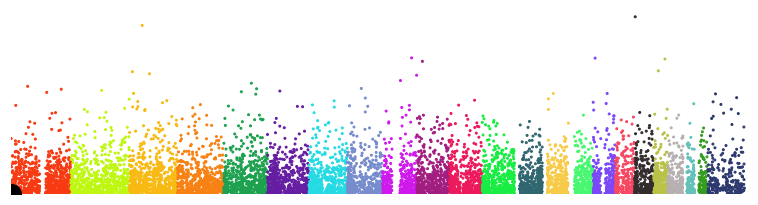

In [183]:
# colors
colors = {1 : "#F73A12", 2 : "#BFF712", 3 : "#F7B912", 4 : "#F78112", 
5 : "#1DA14F", 6 : "#651DA1", 7 : "#26DAE3", 8 : "#768CCC", 
9 : "#CF19EC", 10 : "#A11D7F", 11 : "#EC195C", 12 : "#19EC43", 
13 : "#30666F", 14 : "#F7CA48", 15 : "#48F770", 16 : "#7A48F7", 
17 : "#F74863", 18 : "#322C2D", 19 : "#B9C147", 20 : "#B7B0B1", 
21 : "#64C1B9", 22 : "#349C21", 23 : "#2D396E", 24 : "#5CAEC8"}

sx = manhattan_xy_np[:,1].tolist()
sy = manhattan_xy_np[:,2].tolist()
color_list = list(map(lambda contig: colors[contig], manhattan_xy_np[:,0].flat))

# Create your figure and axes
fig,ax = plt.subplots(1, figsize=(10.24, 2.56))

# Turn off axes and set axes limits
ax.set_yticklabels([])
ax.set_xticklabels([])
ax.axis('off')

ax.set_ylim([.000004,11])
ax.set_xlim([900000,3.05*(10**9)])

plt.gca().xaxis.set_major_locator(matplotlib.ticker.NullLocator())
plt.gca().yaxis.set_major_locator(matplotlib.ticker.NullLocator())
#plt.Axes(fig, [0,0,1,1])

# Set whitespace to 0
fig.subplots_adjust(left=0,right=1,bottom=0,top=1,hspace = 0, wspace = 0)

# Plot the scatter points
ax.scatter(sx, sy,c=color_list,s=4)
ax.scatter(900000,  .000004, c='black',s=400)
plt.savefig('test.png', dpi=100, bbox_inches='tight', pad_inches=0.0)
plt.show()

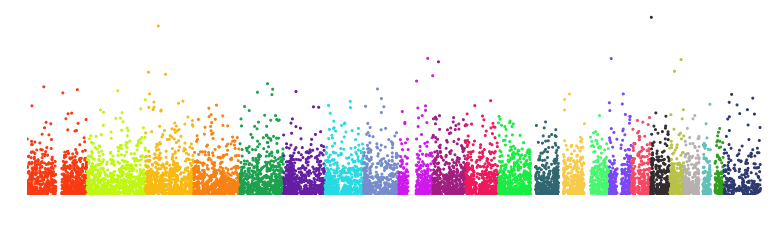

In [193]:
fig = plt.figure(figsize=(10.24, 2.56))
ax=fig.add_axes([0,0,1,1])
ax.set_axis_off()
ax.scatter(sx, sy, c=color_list, s=4)
ax.set_ylim([.000004,11])
ax.set_xlim([900000,3.05*(10**9)])

#ax.set_aspect('auto')
plt.savefig('test.png', dpi=100)
plt.show()

In [217]:
def calculateXRange(column, tile_width, parent_min):
    x_min = tile_width * column + parent_min
    x_max = x_min + tile_width
    return (x_min, x_max)

def calculateYRange(row, total_rows, tile_height, parent_min):
    rows_from_bottom = (total_rows - 1) - row
    y_min = tile_height * rows_from_bottom + parent_min
    y_max = y_min + tile_height
    return (y_min, y_max)
    
# assumes axes start at 0 for x and y
# generate all plots for a given zoom level
def generatePlots(zoom, folder, positions, neg_log_pvals, max_x, max_y):
    total_tiles = 4**zoom
    num_cols = int(math.sqrt(total_tiles))
    num_rows = int(num_cols/4)
    total_rows = num_cols
            
    for c in range(0, num_cols):
        for r in range(total_rows-num_rows, total_rows):
            tile_width = max_x/num_cols
            (x_min, x_max) = calculateXRange(c, tile_width, 0)
            
            tile_height = max_y/num_rows
            (y_min, y_max) = calculateYRange(r, total_rows, tile_height, 0)
            
            filepath = folder+"/"+str(zoom)+"/"+str(c)+"/"+str(r)+".png"
            print("filepath : ", filepath)
            print("xmin: ", x_min)
            print("xmax: ", x_max)
            print("ymin: ", y_min)
            print("ymax: ", y_max)
            print()
        
            generateTileImage(filepath, positions, neg_log_pvals, color_list, [x_min, x_max], [y_min, y_max])
            
def generateTileImage(filepath, positions, neg_log_pvals, color_list, xrange, yrange):
    fig = plt.figure(figsize=(10.24, 2.56))
    ax=fig.add_axes([0,0,1,1])
    ax.set_axis_off()
    ax.scatter(positions, neg_log_pvals, c=color_list, s=4)
    ax.set_ylim(yrange)
    ax.set_xlim(xrange)

    plt.savefig(filepath, dpi=100)
    plt.show()

def makeDirectories(root_folder, zoom, column_range):
    zoom_directory = root_folder + "/" +str(zoom)
    if not os.path.exists(zoom_directory):
        os.makedirs(zoom_directory)
    
    for c in row_range:
        if not os.path.exists(zoom_directory+"/"+str(c))
            os.makedirs(zoom_directory+"/"+str(c))
    
generatePlots(2, "../matplotlib", sx, sy, 3.05*10**9, 11.5)            

filepath :  matplotlib/2/0/3.png
xmin:  0.0
xmax:  762500000.0
ymin:  0.0
ymax:  11.5



FileNotFoundError: [Errno 2] No such file or directory: 'matplotlib/2/0/3.png'